# Mini Project
# Analyzing Temperature Data in Texas
### Presented by Malachi Hale

# Executive Summary

### Project Goals

The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

For the purposes of this project, I will look at temperature data for Texas.

### Data Source

Use the data from this kaggle competition: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

### Outline

We take the following steps:
 - **Acquire** data from Berkeley Earth through Kaggle.com.
 - **Prepare** data by:
     - setting the date column into datetime format, 
     - setting the new datetime column as the index, 
     - eliminating all columns except index and average temperature,
     - imputing the remaining null values, and 
     - splitting the data into train, validate, and test datasets.   
 - **Explore** the data by graphing distributions of the temperature data. 
 - **Model** the data to predict average temperature. 
 
### Key Findings

The predict based on previous cycle model is the best model for predicting average temperature in Texas. 

### Recommendation

Utilize the previous cycle model to predict future temperatures in Texas. We lack data past 2013, so to predict data for the future (2022), we will need to collect data for the past several years.

# Import Libraries

In [219]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

#Import pandas and numpy
import pandas as pd
import numpy as np

#Import for converting data to datetime
from datetime import datetime 

#Square root import
from math import sqrt

#Imports needed for visualizing data
import matplotlib.pyplot as plt
# %matplotlib inline 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

#Modeling imports
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

#Sklearn imports
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Acquire

We will upload data for the temperature in various locations throughout the world over the past two hundred years. We use a file also contained in this repository.

In [220]:
df = pd.read_csv(r'/Users/malachihale/codeup-data-science/time-series-exercises/GlobalLandTemperaturesByState.csv')

Here we have data for many different regionst throughout the world.

In [221]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


For the purpose of this project, we will select only the data in the state of Texas.

In [222]:
df = df[df.State == "Texas"]

In [223]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [224]:
df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
552047,2013-05-01,22.628,0.158,Texas,United States
552048,2013-06-01,27.841,0.220,Texas,United States
552049,2013-07-01,27.630,0.182,Texas,United States
552050,2013-08-01,28.663,0.247,Texas,United States
552051,2013-09-01,26.408,1.112,Texas,United States


For the sake of data integrity, we will check that all of our Texas data is also in the United States. 

In [225]:
df[df.Country != "United States"]

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country


Since, the above DataFrame is empty, all of our data points are located in the United States.

## Key Takeaways

 - We acquired data from the Kaggle dataset for temperatures around the world over the past 200 years. 
 - We selected just the dat for Texas. 
 - Our data spans January 1820 to September 2013. 
 - Our data is month-to-month.

# Prepare

We will prepare the data by converting our date column to datetime

In [226]:
def prep_data(df):
    '''
    This function converts the date column to datetime format, then sets that 
    column to the index.
    '''
    # Reassign the sale_date column to be a datetime type
    df['date'] = pd.to_datetime(df.dt)
    
    # Sort rows by the date and then set the index as that date
    df = df.set_index("date").sort_index()
    
    #Eliminate all columns except data and Average Temperature
    df = df.groupby(['date'])[['AverageTemperature']].sum()
    
    #Impute any null values in the dataset.
    imputer = SimpleImputer(strategy='mean')

    for col in df.columns:
        df[[col]] = imputer.fit_transform(df[[col]])

    return df

In [227]:
df = prep_data(df)

In [228]:
df.head(3)

,AverageTemperature
date,
1820-01-01,4.489
1820-02-01,9.081
1820-03-01,12.657


In [229]:
df.tail(3)

,AverageTemperature
date,
2013-07-01,27.630
2013-08-01,28.663
2013-09-01,26.408


**Note** 

The data for the final year, 2013, ends in September, and thus is not the complete data for the entire year.

## Split Data

We will split the data into train, validate, and test datasets.

In [230]:
#Set train size
train_size = int(len(df) * .5)
#Set validate size
validate_size = int(len(df) * .3)
#Set test size
test_size = int(len(df) - train_size - validate_size)
#Set index for validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

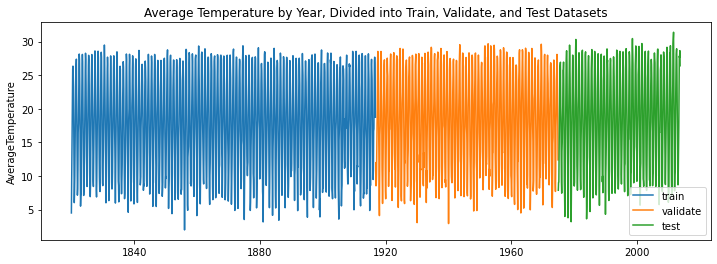

In [231]:
#Graph 
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col], label = "train")
    plt.plot(validate[col], label = "validate")
    plt.plot(test[col], label = "test")
    plt.ylabel(col)
    plt.title("Average Temperature by Year, Divided into Train, Validate, and Test Datasets")
    plt.legend()
    plt.show()

## Key Takeaways
 - We set the date column to datetime format.
 - We set the new date column as the index of the DataFrame. 
 - We eliminated all columns except the date and the average temperatures. 
 - We imputed all null values with the mean of the Average Temperature column. 
 - We manually split the data into train, validate, and, test datasets.

# Exploratory Graphs

We will explore the data by creating a series of graphs that will tell us how are data is distributed. 

In [232]:
y = train.AverageTemperature

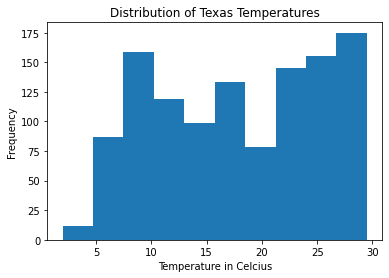

In [233]:
ax = y.plot.hist()
labels = ax.set(Title = "Distribution of Texas Temperatures", xlabel = "Temperature in Celcius")

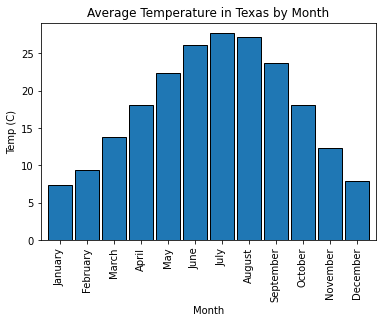

In [234]:
ax = y.groupby(y.index.strftime('%m-%B')).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
title = ax.set(title='Average Temperature in Texas by Month', xlabel='Month', ylabel='Temp (C)')
labels = ax.get_xticklabels()
set_labels = ax.set_xticklabels([l.get_text()[3:] for l in labels])

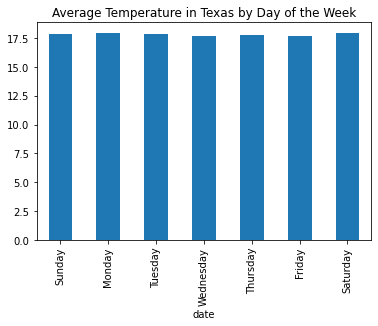

In [235]:
ax = y.groupby(y.index.strftime('%w-%A')).mean().plot.bar()
title = ax.set(title = "Average Temperature in Texas by Day of the Week")
labels = ax.get_xticklabels()
set_labels = ax.set_xticklabels([l.get_text()[2:] for l in labels])

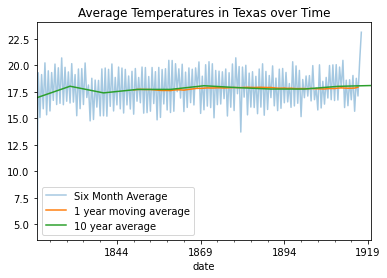

In [236]:
ax = y.resample('6M').mean().plot(label='Six Month Average', alpha=.4)
y.resample('Y').mean().rolling(30).mean().plot(ax=ax, label='1 year moving average')
y.resample('10Y').mean().plot(ax=ax, label='10 year average')
ax.legend()
title = ax.set(title = "Average Temperatures in Texas over Time")

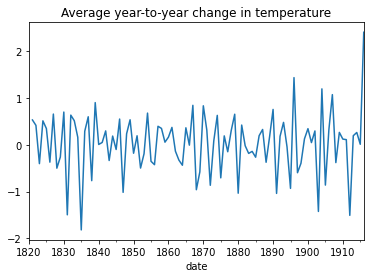

In [237]:
year_to_year = y.resample('1Y').mean().diff().plot(title='Average year-to-year change in temperature')

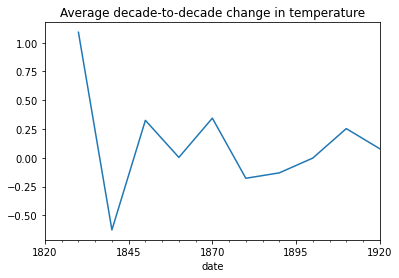

In [238]:
year_to_year = y.resample('10Y').mean().diff().plot(title='Average decade-to-decade change in temperature')

## Key Takeaways
 
 - The distribution of temperature is not normally distributed. 
 - Temperature peaks in summer and has a minimum in winter months. 
 - Temperature is roughly the same based on day of the week. 
 - The longer period we resample data for, the the flatter the average temperature graph becomes. 
 - Average temperature change appears to be roughly consistent. 

# Modeling

## Evalutive Functions

In [239]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This model finds the rmse value of the model.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [240]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    We plot the results of the model and print the RMSE value.
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [241]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    We append the rmse value to a DataFrame.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [242]:
eval_df

,model_type,target_var,rmse


## Forecast

### Simple Average

In [243]:
AverageTemperature = train['AverageTemperature'].mean()

def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature]}
                           , index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [244]:
yhat_df.head()

,AverageTemperature
date,
1916-11-01,17.829652
1916-12-01,17.829652
1917-01-01,17.829652
1917-02-01,17.829652
1917-03-01,17.829652


AverageTemperature -- RMSE: 7


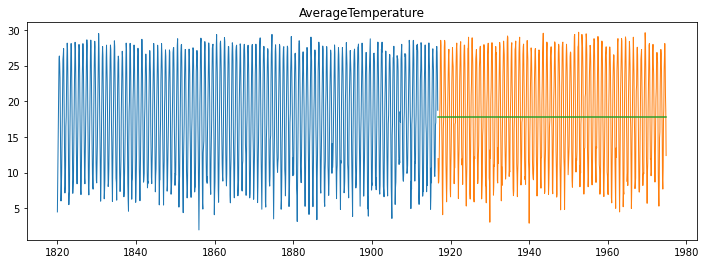

In [245]:
for col in train.columns:
    plot_and_eval(col)

In [246]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [247]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0


## Moving Average

In [248]:
period = 3

AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]

yhat_df = make_predictions()
yhat_df.head(3)

,AverageTemperature
date,
1916-11-01,23.658
1916-12-01,23.658
1917-01-01,23.658


AverageTemperature -- RMSE: 9


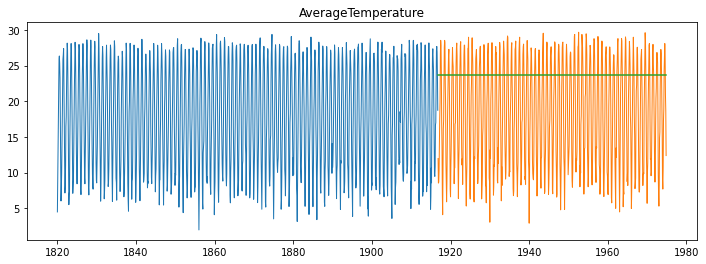

In [249]:
for col in train.columns:
    plot_and_eval(col)

In [250]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = col)

In [251]:
periods = [1, 4, 8, 12, 24]

for p in periods:
    AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]

    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature')

In [252]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,3 month moving average,AverageTemperature,9.0
2,1 month moving average,AverageTemperature,9.0
3,4 month moving average,AverageTemperature,9.0
4,8 month moving average,AverageTemperature,9.0
5,12 month moving average,AverageTemperature,9.0
6,24 month moving average,AverageTemperature,9.0


### Holt's Linear Trend

AverageTemperature 



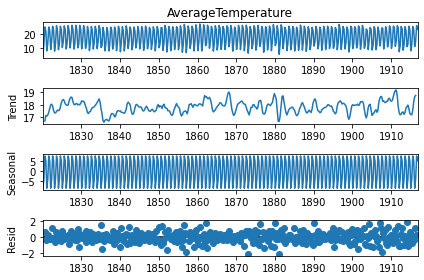

In [253]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [254]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

AverageTemperature -- RMSE: 102


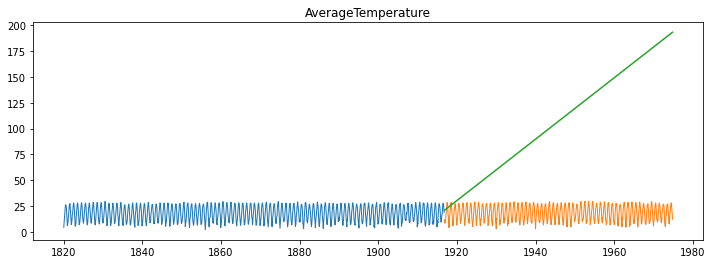

In [255]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [256]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [257]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,3 month moving average,AverageTemperature,9.0
2,1 month moving average,AverageTemperature,9.0
3,4 month moving average,AverageTemperature,9.0
4,8 month moving average,AverageTemperature,9.0
5,12 month moving average,AverageTemperature,9.0
6,24 month moving average,AverageTemperature,9.0
7,Holts,AverageTemperature,102.0


### Previous Cycle Model

We have to split our data into new train, test, and validate datasets. Since our data ends in September 2013, and and the rest of the years include data for the full year, we will have to split our data up by month if we want equal validate and test datasets.

In [258]:
train = df[:'1955-09']
validate = df['1955-10':'1984-09']
test = df['1984-10':'2013']

In [259]:
len(train)

1629

In [260]:
len(validate)

348

In [261]:
len(test)

348

In [262]:
yhat_df = train['1926-10':'1955-09'] - train.diff(348).mean()

In [263]:
yhat_df = yhat_df.set_index(validate.index)

In [264]:
len(yhat_df)

348

AverageTemperature -- RMSE: 2


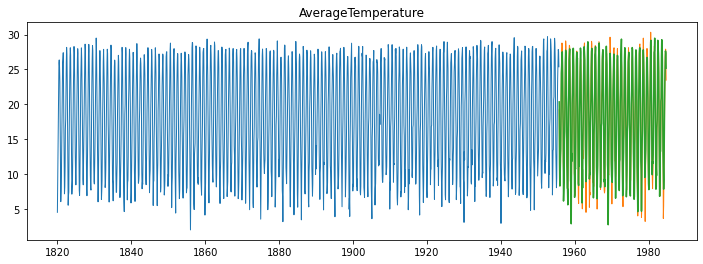

In [265]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [266]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,3 month moving average,AverageTemperature,9.0
2,1 month moving average,AverageTemperature,9.0
3,4 month moving average,AverageTemperature,9.0
4,8 month moving average,AverageTemperature,9.0
5,12 month moving average,AverageTemperature,9.0
6,24 month moving average,AverageTemperature,9.0
7,Holts,AverageTemperature,102.0
8,previous year,AverageTemperature,2.0


## Key Takeaway 

 - Given the RMSE value, the previous cycle model appears to have predicted the average temperature most effectively. 
    - This model has an RMSE value of 2.0, less than the baseline value. Therefore, this model is valid.

# Conclusion

In [267]:
min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse) 
        )]

,model_type,target_var,rmse
8,previous year,AverageTemperature,2.0


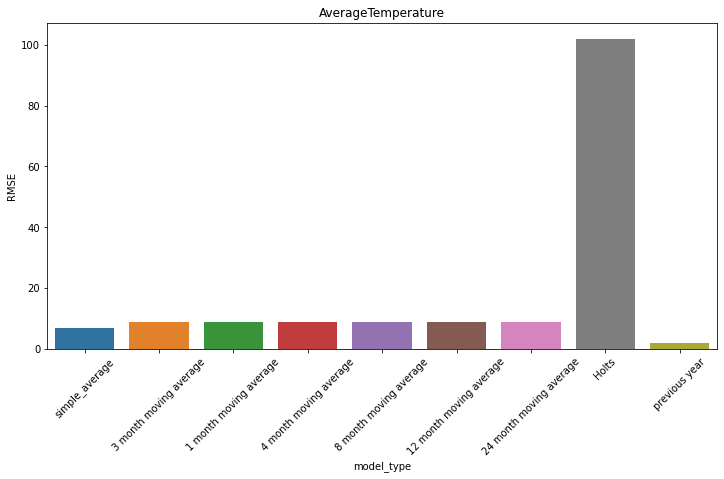

In [268]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

The Holt's model is by far the worst, so we will drop it. 

In [269]:
eval_df = eval_df.drop([7])

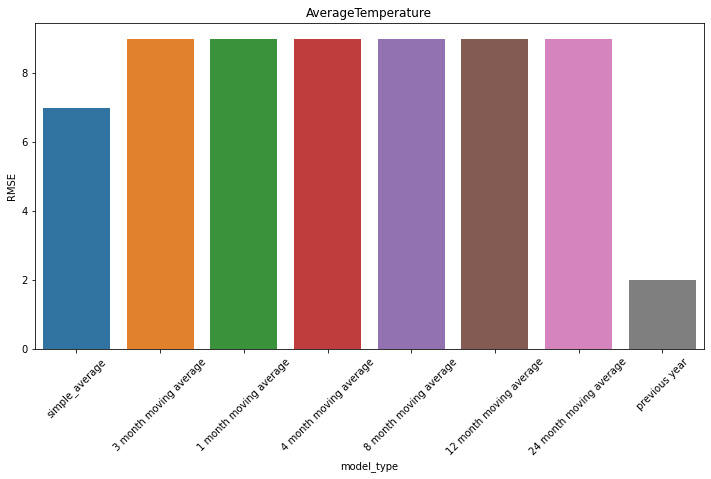

In [270]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Since our previous year model is our best model, we will run that model on our test dataset.

In [272]:
len(validate)

348

In [271]:
len(test)

348

In [273]:
yhat_df = validate + train.diff(348).mean()
yhat_df.index = test.index

In [274]:
yhat_df.head()

,AverageTemperature
date,
1984-10-01,19.390267
1984-11-01,12.918267
1984-12-01,9.544267
1985-01-01,8.481267
1985-02-01,10.097267


In [275]:
rmse = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature'])), 0)
rmse

2.0

In [276]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

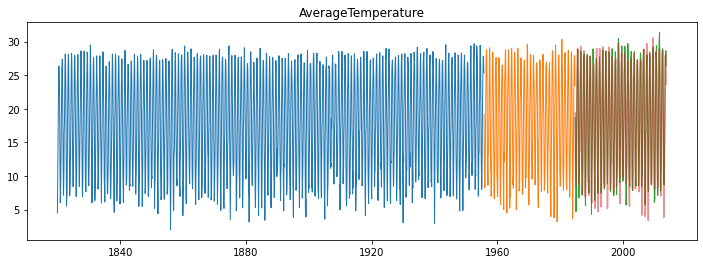

In [277]:
for col in train.columns:
    plot_and_eval(col)

## Key Takeaways

 - The RMSE value for the previous cycle model on our test dataset beats our baseline. Therefore, this model is valid. 

# Predicting beyond the Dataset post-2013

In [282]:
test.head()

,AverageTemperature
date,
1984-10-01,18.745
1984-11-01,12.776
1984-12-01,11.515
1985-01-01,4.699
1985-02-01,7.731


In [283]:
test.tail()

,AverageTemperature
date,
2013-05-01,22.628
2013-06-01,27.841
2013-07-01,27.630
2013-08-01,28.663
2013-09-01,26.408


In [284]:
len(test)

348

We will predict values 348 months after the end of our test dataset.

In [313]:
date_range = pd.DataFrame({'date': pd.date_range(datetime(2013,10,1), datetime(2042,10,1), freq='M')})

In [314]:
date_range = date_range.set_index(date_range.date)

In [315]:
date_range.head()

,date
date,
2013-10-31,2013-10-31
2013-11-30,2013-11-30
2013-12-31,2013-12-31
2014-01-31,2014-01-31
2014-02-28,2014-02-28


In [316]:
date_range.tail()

,date
date,
2042-05-31,2042-05-31
2042-06-30,2042-06-30
2042-07-31,2042-07-31
2042-08-31,2042-08-31
2042-09-30,2042-09-30


In [317]:
len(date_range)

348

In [318]:
yhat_df = test + train.diff(348).mean()

In [319]:
yhat_df = yhat_df.set_index(date_range.index)

In [320]:
yhat_df.head()

,AverageTemperature
date,
2013-10-31,18.946267
2013-11-30,12.977267
2013-12-31,11.716267
2014-01-31,4.900267
2014-02-28,7.932267


In [321]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title("Average Temperature, Predicted into the Future")
    plt.show()

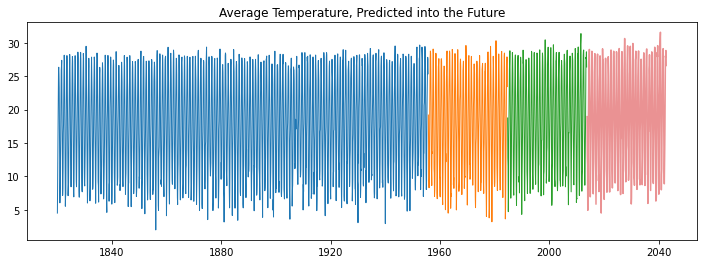

In [322]:
for col in train.columns:
    plot_and_eval(col)

## Key Takeaways

 - Assuming the temperature in the past is predictive of the temperature in the future, the graph above represents what we can expect to see of temperatures in the future. 